In [242]:
import ast
from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, MiniBatchKMeans

In [243]:
# Set the number of neurons to the same number as the loaded model
som_neurons = (38, 38)
model_id = 4
ClusterClass = AgglomerativeClustering
# ClusterClass = MiniBatchKMeans
# features = ['instrumentalness', 'danceability']
features = ['acousticness', 'instrumentalness', 'loudness', 'energy', 'danceability', 'valence', 'explicit']

genres = ["rock",
          "classical",
          "latin",
          "pop",
          "jazz",
          "soul",
          "classic bollywood",
          "rap",
          "folk",
          "funk",
          "opera"]
clusters = len(genres)

rng = np.random.default_rng()
cluster_class_name = ClusterClass.__name__
model_name = f'{cluster_class_name}_model_{model_id}'
model_path = f'../models/{model_name}.p'

## Data
Select a subset of tracks from some genres, and under sample the genres
to the size of the smallest genre.

In [244]:
tracks = pd.read_csv('../data/tracks_with_genres.csv')
tracks['genres'] = tracks['genres'].apply(ast.literal_eval)
tracks = tracks.explode('genres')
tracks.rename(columns={'genres': 'genre'}, inplace=True)
tracks_subset = tracks[tracks['genre'].isin(genres)]

rus = RandomUnderSampler(random_state=1)
X, y = rus.fit_resample(tracks_subset, tracks_subset['genre'])

tracks_genres = y.astype('category')

print(f'In total, there are {y.shape[0]} tracks in the dataset used.')

In total, there are 84084 tracks in the dataset used.


Convert the pandas dataframe to a matrix of numerical values, normalize the values column wise and shuffle the rows.

In [245]:
tracks_values = X[features].values
tracks_values = (tracks_values - tracks_values.mean(axis=0))/tracks_values.std(axis=0)
rng.shuffle(tracks_values, axis=0)

In [246]:
def no_decay(param, t, max_iter):
    return param

# Load model
with open(model_path, 'rb') as model_file:
    som = pickle.load(model_file)

In [254]:
# Skip this, the activation map is not interesting

# neuron_activations = som.activation_response(tracks_values)
#
# sns.set_style('white')
# ax = sns.heatmap(neuron_activations, cbar_kws={'label': 'Number of activations'})
# ax.get_figure().tight_layout()
# plt.axis('off')
# plt.show()
# ax.get_figure().savefig(f'../output/figures/{model_name}_activations.png', bbox_inches='tight')

Display the distance map.

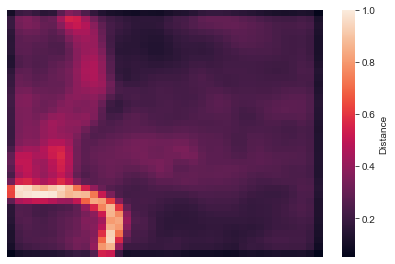

In [252]:
sns.set_style('white')
ax = sns.heatmap(som.distance_map(), cbar_kws={'label': 'Distance'})
ax.get_figure().tight_layout()
plt.axis('off')
plt.show()
ax.get_figure().savefig(f'../output/figures/{model_name}_distance.png', bbox_inches='tight')

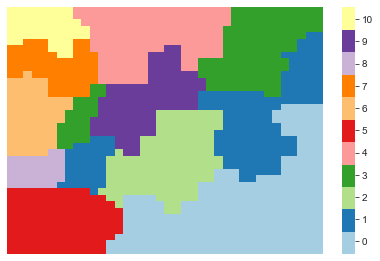

In [249]:
cluster = ClusterClass(n_clusters=clusters)
som_weights = som.get_weights()
labels = cluster.fit_predict(
    som_weights.reshape(som_neurons[0]*som_neurons[1], len(features))
)

labels_matrix = labels.reshape(som_neurons[0], som_neurons[1])
ax = sns.heatmap(labels_matrix, cmap=sns.color_palette('Paired', clusters))
#activation_ax = sns.heatmap(som.distance_map(), cbar=False, ax=heatmap, alpha=0.3)
fig = ax.get_figure().tight_layout()

cbar = ax.collections[0].colorbar
tick_locs = np.linspace(0.5, clusters-1.5, clusters)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(list(range(clusters)))

ax.axis('off')
ax.get_figure().savefig(f'../output/figures/{model_name}_clusters.png', bbox_inches='tight')
plt.show()

In [250]:
labels_map = som.labels_map(tracks_values, tracks_genres)
labels_classified_as_genre = [Counter() for i in range(clusters)]

for neuron in range(len(labels)):
    y, x = neuron//som_neurons[1], neuron%som_neurons[1]
    label = labels[neuron]
    counter = labels_map[(y, x)]

    if counter:
        labels_classified_as_genre[label] += counter

for label in labels_classified_as_genre:
    print(label)

Counter({'soul': 1852, 'jazz': 1817, 'funk': 1807, 'latin': 1802, 'opera': 1794, 'pop': 1786, 'classic bollywood': 1777, 'classical': 1771, 'rap': 1764, 'rock': 1761, 'folk': 1704})
Counter({'classical': 1051, 'rap': 1030, 'rock': 1026, 'pop': 1022, 'latin': 1020, 'opera': 1010, 'soul': 1006, 'folk': 1005, 'funk': 999, 'classic bollywood': 991, 'jazz': 982})
Counter({'soul': 806, 'folk': 794, 'latin': 743, 'rock': 735, 'opera': 731, 'classic bollywood': 726, 'pop': 711, 'funk': 707, 'jazz': 699, 'rap': 689, 'classical': 680})
Counter({'rock': 886, 'rap': 861, 'folk': 859, 'classic bollywood': 849, 'latin': 848, 'pop': 848, 'classical': 847, 'jazz': 845, 'opera': 820, 'funk': 818, 'soul': 796})
Counter({'rap': 852, 'classical': 843, 'latin': 826, 'classic bollywood': 821, 'folk': 817, 'jazz': 813, 'funk': 811, 'soul': 768, 'pop': 767, 'rock': 767, 'opera': 766})
Counter({'rap': 734, 'funk': 731, 'pop': 719, 'folk': 716, 'opera': 710, 'rock': 710, 'classic bollywood': 706, 'latin': 695, 

Songs per genre and cluster


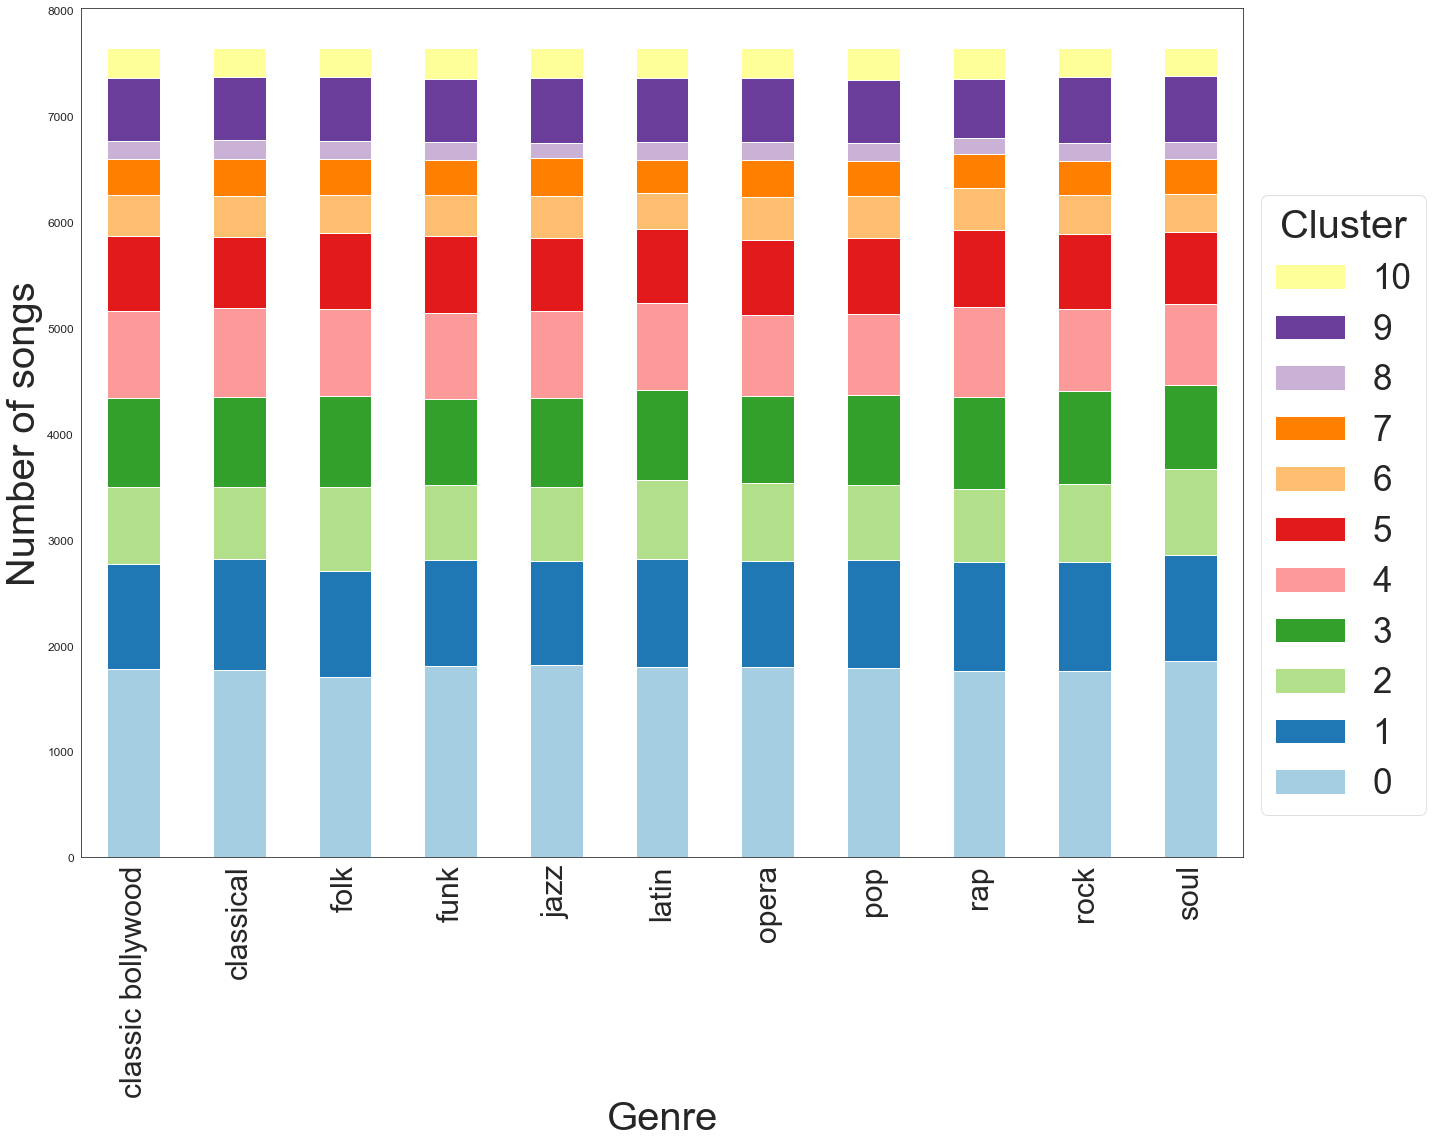

In [251]:
print("Songs per genre and cluster")
classifications = pd.DataFrame(labels_classified_as_genre)
_, ax = plt.subplots()

colormap = ListedColormap(sns.color_palette('Paired', clusters).as_hex())
fig = classifications.T.plot(kind='bar', figsize=(20, 16), fontsize=12, stacked=True, ax=ax,
                             cmap=colormap).get_figure()
ax.set_ylabel("Number of songs", fontsize='40')
ax.set_xlabel("Genre", fontsize='40')
handles, labels = ax.get_legend_handles_labels()

ax.legend(reversed(handles), reversed(labels), title='Cluster', title_fontsize='40', bbox_to_anchor = (1.0, 0.8),
          mode='none', ncol=1,fontsize='35',framealpha=0.6, )
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)
fig.tight_layout()
plt.savefig(f'../output/figures/{model_name}_genre_clusters_bars.png')
plt.show()